In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip3 install mne
%matplotlib inline

     |████████████████████████████████| 6.8MB 5.3MB/s 


In [ ]:
import os
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sn

import mne
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)
from mne.decoding import UnsupervisedSpatialFilter

import matplotlib.pyplot as plt
import matplotlib.colors

from ipywidgets import interact

from sklearn.decomposition import PCA, FastICA
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import label_binarize

from sklearn.externals import joblib

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from imblearn.under_sampling import ClusterCentroids
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

import sys
sys.path.append('/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/NL_PCA')
from sklearn_nlpca import NLPCA

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functio

In [ ]:
# Matriz de confusion
def plot_matriz_confusion(y_test, y_predict, labels, save=None, name_fig='fig_1.svg', file_directory='', titulo='Matriz de confusión', figsize = (7,5)):
  
    cm = confusion_matrix(y_test, y_predict)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100

    annot = np.empty_like(cm).astype(np.dtype('U30'))
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d\n' % (p, c, s)
            else:
                annot[i, j] = '%.2f%%\n%d/%d\n' % (p, c, s)
              
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Estimados'
    cm.columns.name = 'Verdaderos'

    fig = plt.figure(figsize = figsize)
    fig.patch.set_facecolor('White')
    ax = fig.add_subplot(1,1,1)

    ax.set_title(titulo,fontdict={'weight': 'normal','size':20})
    ax.axhline(y=0, color='Black',linewidth=0.2)
    ax.axhline(y=2, color='Black',linewidth=0.2)
    ax.axvline(x=0, color='Black',linewidth=0.2)
    ax.axvline(x=2, color='Black',linewidth=0.2)

    sn.set(font_scale=1.2)  
    sn.heatmap(cm, cmap= "Blues", annot=annot, fmt='', linecolor='Black',linewidths=.1, cbar=None)

    if save==True:
        sns_plot = sn.heatmap(cm, cmap= "Blues", annot=annot, fmt='', linecolor='Black',linewidths=.1, cbar=None)
        fig = sns_plot.get_figure()
        fig.savefig(file_directory+name_fig)
        
# Matriz de confusion con rechazo
def plot_matriz_confusion_rechazo(y_test, y_predict, labels, save=None, name_fig='fig_1.svg', file_directory='', titulo='Matriz de confusión'):
  
    cm = confusion_matrix(y_test, y_predict)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if np.isnan(cm_perc[i][j]):
                cm_perc[i][j]=0
                

    annot = np.empty_like(cm).astype(np.dtype('U30'))
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            else:
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
              
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Estimados'
    cm.columns.name = 'Verdaderos'

    fig = plt.figure(figsize = (7,5))
    fig.patch.set_facecolor('White')
    ax = fig.add_subplot(1,1,1)

    ax.set_title(titulo,fontdict={'weight': 'normal','size':20})
    ax.axhline(y=0, color='Black',linewidth=0.2)
    ax.axhline(y=2, color='Black',linewidth=0.2)
    ax.axhline(y=3, color='Black',linewidth=0.2)
    ax.axvline(x=0, color='Black',linewidth=0.2)
    ax.axvline(x=2, color='Black',linewidth=0.2)
    ax.axvline(x=3, color='Black',linewidth=0.2)

    sn.set(font_scale=1.2)  
    sn.heatmap(cm, cmap= "Blues", annot=annot, fmt='', linecolor='Black',linewidths=.1, cbar=None)

    if save==True:
        sns_plot = sn.heatmap(cm, cmap= "Blues", annot=annot, fmt='', linecolor='Black',linewidths=.1, cbar=None)
        fig = sns_plot.get_figure()
        fig.savefig(file_directory+name_fig)
        
# Seleccion del folder actual
currentFolder = os.getcwd()

In [ ]:
# Return X and y data from Epoched Dataframe
# X: EEG data, in format Ntrials x Nchannels X Nsamples
# y: labels
def getEEGXY(df, channels, columnClass, ColumnEpoch):
  import numpy as np
  classes = df[columnClass].unique()
  X = []
  y = []
  for label in classes:
    dfClass = df[df[columnClass]==label]
    epochs = dfClass[ColumnEpoch].unique()
    for epoch in epochs:
      dfEpoch = dfClass[dfClass[ColumnEpoch]==epoch]
      y.append(label)
      X.append(np.transpose(dfEpoch[channels].values))
  return np.stack(X,axis=0), np.array(y)

In [ ]:
baseDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Dataset_descargados/OSF_Storage/RawData/'
trainDir_Raw = '/content/drive/My Drive/TG - Christian Camilo Rosero/Codigo/OSF_Storage(1)/RawData/'
subject = '01'

path_raw_train_per = trainDir_Raw + 'subj' + subject + '/' + 'ses' + '01' + '/' + 'per' + '/'
path_raw_train_per_2 = trainDir_Raw + 'subj' + subject + '/' + 'ses' + '02' + '/' + 'per' + '/'
path_raw_train_img = trainDir_Raw + 'subj' + subject + '/' + 'ses' + '01' + '/' + 'img' + '/'
path_raw_train_img_2 = trainDir_Raw + 'subj' + subject + '/' + 'ses' + '02' + '/' + 'img' + '/'

# Clasificación con Morlet

> Con los 10 Componenetes NLPCA aplicado antes de morlet



In [ ]:
#Llamamos las dos sesiones de percepción del sujeto 
morlet_alpha_time_per = pd.read_csv(path_raw_train_per +'Caracteristicas_NLPCA_ICA_Morlet_Time_Alpha')
morlet_alpha_time_per_2 = pd.read_csv(path_raw_train_per_2 +'Caracteristicas_NLPCA_ICA_Morlet_Time_Alpha')
morlet_alpha_time_per_2['epoch'] = np.array(morlet_alpha_time_per_2['epoch'].values.tolist())+480
morlet_alpha_time_per = pd.concat([morlet_alpha_time_per, morlet_alpha_time_per_2], axis=0)
morlet_alpha_time_per

In [ ]:
morlet_alpha_time_img = pd.read_csv(path_raw_train_img +'Caracteristicas_NLPCA_ICA_Morlet_Time_Alpha')
morlet_alpha_time_img_2 = pd.read_csv(path_raw_train_img_2 +'Caracteristicas_NLPCA_ICA_Morlet_Time_Alpha')
morlet_alpha_time_img_2['epoch'] = np.array(morlet_alpha_time_img_2['epoch'].values.tolist())+480
morlet_alpha_time_img = pd.concat([morlet_alpha_time_img, morlet_alpha_time_img_2], axis=0)
morlet_alpha_time_img

In [ ]:
vectorizer_per = Vectorizer()
vectorizer_img = Vectorizer()

IP_names = []
for i in range(0,10):
  IP_names.append('Morlet_IPC'+str(i))

Xp, yp = getEEGXY(morlet_alpha_time_per, channels=IP_names, columnClass='class', ColumnEpoch='epoch')

Xi, yi = getEEGXY(morlet_alpha_time_img, channels=IP_names, columnClass='class', ColumnEpoch='epoch')

Xp = vectorizer_per.fit_transform(Xp, yp)
Xi = vectorizer_img.fit_transform(Xi, yi)

classes_names = list(morlet_alpha_time_per['condition'].unique())
classes = list(morlet_alpha_time_per['class'].unique())

In [ ]:
pseudo_trials = 4 
trials_for_class = dict(zip(classes,[4  for n in range(0,12)]))
cc = ClusterCentroids(sampling_strategy=trials_for_class,random_state=None,voting='hard')
Xp_resampled, yp_resampled = cc.fit_resample(Xp, yp)
Xp_resampled = vectorizer_per.inverse_transform(Xp_resampled)
Xi_resampled, yi_resampled = cc.fit_resample(Xi, yi)
Xi_resampled = vectorizer_img.inverse_transform(Xi_resampled)

(48, 10, 136)

In [ ]:
svc = SVC(kernel="linear", C=1, decision_function_shape='ovo')
clf = make_pipeline(StandardScaler(), svc)

time_gen = GeneralizingEstimator(clf, n_jobs=1, scoring='accuracy',
                                 verbose=True)
time_gen.fit(Xp_resampled,yp_resampled)
scores = time_gen.score(Xi_resampled,yi_resampled)

In [ ]:
times_per = np.arange(-200,800,20)/1000
times_img = np.arange(-200,2500,20)/1000
fig, ax = plt.subplots(1)
im = ax.matshow(scores.T, cmap='RdBu_r', origin='lower',
                extent=np.hstack([times_per[[0, -1]],times_img[[0, -1]]]))
ax.axhline(0., color='k')
ax.axvline(0., color='k')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Percepciom Time (s)')
ax.set_ylabel('Imagery Time (s)')
ax.set_title('Generalization across time Percepción Train')
plt.colorbar(im, ax=ax)
plt.show()

In [ ]:
#Visulaizar promedio de generalización percepción vs imaginaciónde los 12 objetos 

svc = SVC(kernel="linear", C=1, decision_function_shape='ovo')
clf = make_pipeline(StandardScaler(), svc)

vectorizer_per = Vectorizer()
vectorizer_img = Vectorizer()

IP_names = []
for i in range(0,10):
  IP_names.append('Morlet_IPC'+str(i))

Xp, yp = getEEGXY(morlet_alpha_time_per, channels=IP_names, columnClass='class', ColumnEpoch='epoch')

Xi, yi = getEEGXY(morlet_alpha_time_img, channels=IP_names, columnClass='class', ColumnEpoch='epoch')

Xp = vectorizer_per.fit_transform(Xp, yp)
Xi = vectorizer_img.fit_transform(Xi, yi)

classes_names = list(morlet_alpha_time_per['condition'].unique())
classes = list(morlet_alpha_time_per['class'].unique())

pseudo_trials = 4
trials_for_class = dict(zip(classes,[4  for n in range(0,12)]))

scores_nlpca_per_img = []

for i in range(0,100):
  cc = ClusterCentroids(sampling_strategy=trials_for_class,random_state=None,voting='hard')
  Xp_resampled, yp_resampled = cc.fit_resample(Xp, yp)
  Xp_resampled = vectorizer_per.inverse_transform(Xp_resampled)
  Xi_resampled, yi_resampled = cc.fit_resample(Xi, yi)
  Xi_resampled = vectorizer_img.inverse_transform(Xi_resampled)

  time_gen = GeneralizingEstimator(clf, n_jobs=2, scoring='accuracy',verbose=True)
  time_gen.fit(Xp_resampled,yp_resampled)
  scores = time_gen.score(Xi_resampled,yi_resampled)
  scores_nlpca_per_img.append(scores)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (-2 , 2))
score = np.mean(np.array(scores_nlpca_per_img),axis=0)*10
score = scaler.fit_transform(score)
times_per = np.arange(-200,800,20)/1000
times_img = np.arange(-200,2500,20)/1000
fig, ax = plt.subplots(1, figsize = (15,10))
im = ax.matshow(score.T, interpolation='lanczos', vmin = -2., vmax= 2.,cmap='RdYlBu_r', origin='lower',
                extent=np.hstack([times_per[[0, -1]],times_img[[0, -1]]]))
#im = ax.matshow(score.T, cmap='RdYlBu_r', origin='lower')
ax.axhline(0., color='k')
ax.axvline(0., color='k')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Percepciom Time (s)')
ax.set_ylabel('Imagery Time (s)')
ax.set_title('Generalization across time Alpha Train Perception preNLPCA')
plt.colorbar(im, ax=ax)
plt.show()
fig.savefig(trainDir_Raw + 'subj' + subject + '/Generalization across time Alpha Train Perception preNLPCA', format='png',transparent=True)

In [ ]:
scores_nlpca_img_per = []

for i in range(0,100):
  cc = ClusterCentroids(sampling_strategy=trials_for_class,random_state=None,voting='hard')
  Xp_resampled, yp_resampled = cc.fit_resample(Xp, yp)
  Xp_resampled = vectorizer_per.inverse_transform(Xp_resampled)
  Xi_resampled, yi_resampled = cc.fit_resample(Xi, yi)
  Xi_resampled = vectorizer_img.inverse_transform(Xi_resampled)

  time_gen = GeneralizingEstimator(clf, n_jobs=-1, scoring='accuracy', verbose=True)
  time_gen.fit(Xi_resampled,yi_resampled)
  scores = time_gen.score(Xp_resampled,yp_resampled)
  scores_nlpca_img_per.append(scores)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (-2 , 2))
score = np.mean(np.array(scores_nlpca_img_per),axis=0)
score = scaler.fit_transform(score)
times_per = np.arange(-200,800,20)/1000
times_img = np.arange(-200,2500,20)/1000
fig, ax = plt.subplots(1, figsize = (15,10))
im = ax.matshow(score, interpolation='lanczos', vmin = -2., vmax= 2.,cmap='RdYlBu_r', origin='lower',
                extent=np.hstack([times_per[[0, -1]],times_img[[0, -1]]]))
#im = ax.matshow(score.T, cmap='RdYlBu_r', origin='lower')
ax.axhline(0., color='k')
ax.axvline(0., color='k')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Percepciom Time (s)')
ax.set_ylabel('Imagery Time (s)')
ax.set_title('Generalization across time Alpha Train Imagery PreNLPCA')
plt.colorbar(im, ax=ax)
plt.show()
fig.savefig(trainDir_Raw + 'subj' + subject + '/Generalization across time Alpha Train Imagery PreNLPCA', format='png',transparent=True)

In [ ]:
#Analisis en el tiempo percepción
svc = SVC(kernel="linear", C=1, decision_function_shape='ovo')
clf = make_pipeline(StandardScaler(), svc)

vectorizer_per = Vectorizer()
vectorizer_img = Vectorizer()

IP_names = []
for i in range(0,10):
  IP_names.append('Morlet_IPC'+str(i))

Xp, yp = getEEGXY(morlet_alpha_time_per, channels=IP_names, columnClass='class', ColumnEpoch='epoch')

Xi, yi = getEEGXY(morlet_alpha_time_img, channels=IP_names, columnClass='class', ColumnEpoch='epoch')

Xp = vectorizer_per.fit_transform(Xp, yp)
Xi = vectorizer_img.fit_transform(Xi, yi)

svc = SVC(kernel="linear", C=1, decision_function_shape='ovo')
clf = make_pipeline(StandardScaler(), svc)

pseudo_trials = 4
trials_for_class = dict(zip(classes,[4  for n in range(0,12)]))

scores_nlpca_per = []
scores_nlpca_img = []

for i in range(0,100):
  cc = ClusterCentroids(sampling_strategy=trials_for_class,random_state=None,voting='hard')
  Xp_resampled, yp_resampled = cc.fit_resample(Xp, yp)
  Xp_resampled = vectorizer_per.inverse_transform(Xp_resampled)
  Xi_resampled, yi_resampled = cc.fit_resample(Xi, yi)
  Xi_resampled = vectorizer_img.inverse_transform(Xi_resampled)

  time_decod = SlidingEstimator(clf, n_jobs=-1, scoring='accuracy', verbose=True)
  scores_p = cross_val_multiscore(time_decod, Xp_resampled, yp_resampled, cv=4, n_jobs=-1)
  scores_i = cross_val_multiscore(time_decod, Xi_resampled, yi_resampled, cv=4, n_jobs=-1)

  # Mean scores across cross-validation splits
  scores_p = np.mean(scores_p, axis=0)
  scores_i = np.mean(scores_i, axis=0)

  scores_per.append(scores_p)
  scores_img.append(scores_i)

# Clasificación con Morlet
Con los 63 canales, sin Componentes NLPCA 

In [ ]:
Fs=50
#Llamamos las dos sesiones de percepción del sujeto 
per = pd.read_csv(path_raw_train_per +'Time_frequency_decomposition_Alpha')
per_2 = pd.read_csv(path_raw_train_per_2 +'Time_frequency_decomposition_Alpha')
per_2['epoch'] = np.array(per_2['epoch'].values.tolist())+480
per = pd.concat([per, per_2], axis=0)
#Llamamos las dos sesiones de imaginación del sujeto
img = pd.read_csv(path_raw_train_img +'Time_frequency_decomposition_Alpha')
img_2 = pd.read_csv(path_raw_train_img_2 +'Time_frequency_decomposition_Alpha')
img_2['epoch'] = np.array(img_2['epoch'].values.tolist())+480
img = pd.concat([img, img_2], axis=0)

#Visulaizar promedio de generalización percepción vs imaginaciónde los 12 objetos 

svc = SVC(kernel="linear", C=1, decision_function_shape='ovo')
#svc = OneVsOneClassifier(SVC(kernel="linear", C=1), n_jobs=-1)
clf = make_pipeline(StandardScaler(), svc)

vectorizer_per = Vectorizer()
vectorizer_img = Vectorizer()

Xp, yp = getEEGXY(per, channels=per.columns[5:69], columnClass='class', ColumnEpoch='epoch')

Xi, yi = getEEGXY(img, channels=img.columns[5:69], columnClass='class', ColumnEpoch='epoch')

#Extraer el sector temporal de interes
tp1, tp2 = (-0.2,0.8)
p1 = int((Fs/1000)*(600+1000*tp1)) #-500ms
p2 = int((Fs/1000)*(600+1000*tp2)) #-300ms
Xp = Xp[:,:,p1:p2]

ti1, ti2 = (-0.2,2.5)
i1 = int((Fs/1000)*(600+1000*ti1)) #-500ms
i2 = int((Fs/1000)*(600+1000*ti2)) #-300ms
Xi = Xi[:,:,i1:i2]

Xp = vectorizer_per.fit_transform(Xp, yp)
Xi = vectorizer_img.fit_transform(Xi, yi)

classes_names = list(per['condition'].unique())
classes = list(per['class'].unique())

porcent_trial = int((0.25)*len(Xp)/12)
pseudo_trials = 4
samples_for_class = dict(zip(classes,[porcent_trial  for n in range(0,12)]))
average_for_class = dict(zip(classes,[1  for n in range(0,12)]))

In [ ]:
scores_per_img = []

for i in range(0,100):
  Xp_resampled = []
  yp_resampled = []
  Xi_resampled = []
  yi_resampled = []
  for n in range(0,pseudo_trials):
    rus = RandomUnderSampler(sampling_strategy=samples_for_class,random_state=None)
    Xp_res, yp_res = rus.fit_resample(Xp, yp)
    Xi_res, yi_res = rus.fit_resample(Xi, yi)
    
    cc = ClusterCentroids(sampling_strategy=average_for_class,random_state=None,voting='soft')
    Xp_res, yp_res = cc.fit_resample(Xp_res, yp_res)
    Xi_res, yi_res = cc.fit_resample(Xi_res, yi_res)
    
    Xp_resampled.append(Xp_res)
    yp_resampled.append(yp_res)
    Xi_resampled.append(Xi_res)
    yi_resampled.append(yi_res)

  Xp_resampled = np.reshape(np.array(Xp_resampled),(pseudo_trials*12,-1))
  yp_resampled = np.ravel(np.reshape(np.array(yp_resampled),(pseudo_trials*12,-1)))
  Xi_resampled = np.reshape(np.array(Xi_resampled),(pseudo_trials*12,-1))
  yi_resampled = np.ravel(np.reshape(np.array(yi_resampled),(pseudo_trials*12,-1)))
  
  Xp_resampled = vectorizer_per.inverse_transform(Xp_resampled)
  Xi_resampled = vectorizer_img.inverse_transform(Xi_resampled)

  time_gen = GeneralizingEstimator(clf, n_jobs=2-1, scoring='accuracy',verbose=True)
  time_gen.fit(Xp_resampled,yp_resampled)
  scores = time_gen.score(Xi_resampled,yi_resampled)
  scores_per_img.append(scores)

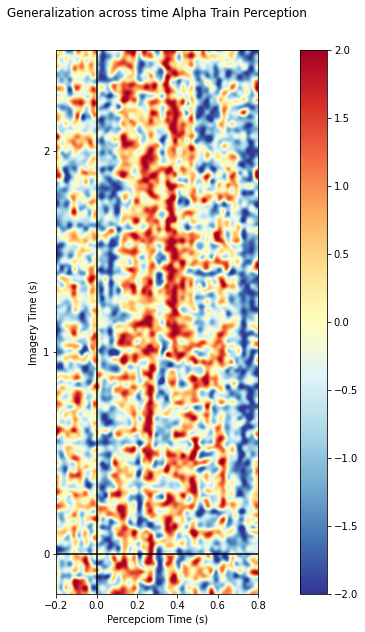

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (-2 , 2))
score = (np.mean(np.array(scores_per_img),axis=0))
score = scaler.fit_transform(score)
times_per = np.arange(-200,820,20)/1000
times_img = np.arange(-200,2520,20)/1000
fig, ax = plt.subplots(1, figsize = (15,10))
im = ax.matshow(score.T, interpolation='lanczos', vmin = -2., vmax= 2.,cmap='RdYlBu_r', origin='lower',
                extent=np.hstack([times_per[[0, -1]],times_img[[0, -1]]]))
# im = ax.matshow(score.T, interpolation='lanczos', cmap='RdYlBu_r', origin='lower',
#                 extent=np.hstack([times_per[[0, -1]],times_img[[0, -1]]]))
# im = ax.matshow(score.T, interpolation='lanczos', cmap='RdYlBu_r', origin='lower')
ax.axhline(0., color='k')
ax.axvline(0., color='k')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Percepciom Time (s)')
ax.set_ylabel('Imagery Time (s)')
ax.set_title('Generalization across time Alpha Train Perception')
plt.colorbar(im, ax=ax)
plt.show()
fig.savefig(trainDir_Raw + 'subj' + subject + '/Generalization across time Alpha Train Perception', format='png',transparent=True)

In [ ]:
scores_img_per = []

for i in range(0,100):
  Xp_resampled = []
  yp_resampled = []
  Xi_resampled = []
  yi_resampled = []
  for n in range(0,pseudo_trials):
    rus = RandomUnderSampler(sampling_strategy=samples_for_class,random_state=None)
    Xp_res, yp_res = rus.fit_resample(Xp, yp)
    Xi_res, yi_res = rus.fit_resample(Xi, yi)
    
    cc = ClusterCentroids(sampling_strategy=average_for_class,random_state=None,voting='soft')
    Xp_res, yp_res = cc.fit_resample(Xp_res, yp_res)
    Xi_res, yi_res = cc.fit_resample(Xi_res, yi_res)
    
    Xp_resampled.append(Xp_res)
    yp_resampled.append(yp_res)
    Xi_resampled.append(Xi_res)
    yi_resampled.append(yi_res)

  Xp_resampled = np.reshape(np.array(Xp_resampled),(pseudo_trials*12,-1))
  yp_resampled = np.ravel(np.reshape(np.array(yp_resampled),(pseudo_trials*12,-1)))
  Xi_resampled = np.reshape(np.array(Xi_resampled),(pseudo_trials*12,-1))
  yi_resampled = np.ravel(np.reshape(np.array(yi_resampled),(pseudo_trials*12,-1)))
  
  Xp_resampled = vectorizer_per.inverse_transform(Xp_resampled)
  Xi_resampled = vectorizer_img.inverse_transform(Xi_resampled)

  time_gen = GeneralizingEstimator(clf, n_jobs=2-1, scoring='accuracy',verbose=True)
  time_gen.fit(Xi_resampled,yi_resampled)
  scores = time_gen.score(Xp_resampled,yp_resampled)
  scores_img_per.append(scores)

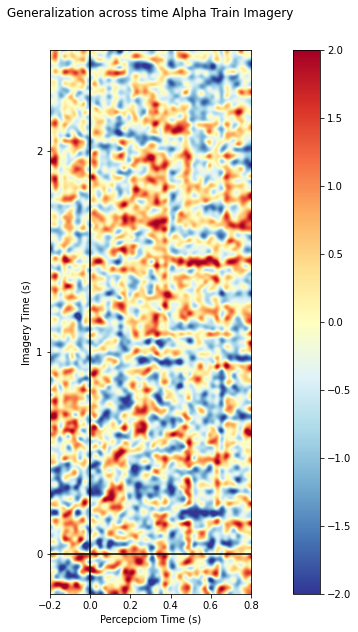

In [63]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (-2 , 2))
score = (np.mean(np.array(scores_img_per),axis=0))
score = scaler.fit_transform(score)
times_per = np.arange(-200,820,20)/1000
times_img = np.arange(-200,2520,20)/1000
fig, ax = plt.subplots(1, figsize = (15,10))
im = ax.matshow(score, interpolation='lanczos', vmin = -2., vmax= 2.,cmap='RdYlBu_r', origin='lower',
                extent=np.hstack([times_per[[0, -1]],times_img[[0, -1]]]))
# im = ax.matshow(score.T, interpolation='lanczos', cmap='RdYlBu_r', origin='lower',
#                 extent=np.hstack([times_per[[0, -1]],times_img[[0, -1]]]))
# im = ax.matshow(score.T, interpolation='lanczos', cmap='RdYlBu_r', origin='lower')
ax.axhline(0., color='k')
ax.axvline(0., color='k')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Percepciom Time (s)')
ax.set_ylabel('Imagery Time (s)')
ax.set_title('Generalization across time Alpha Train Imagery')
plt.colorbar(im, ax=ax)
plt.show()
fig.savefig(trainDir_Raw + 'subj' + subject + '/Generalization across time Alpha Train Imagery', format='png',transparent=True)

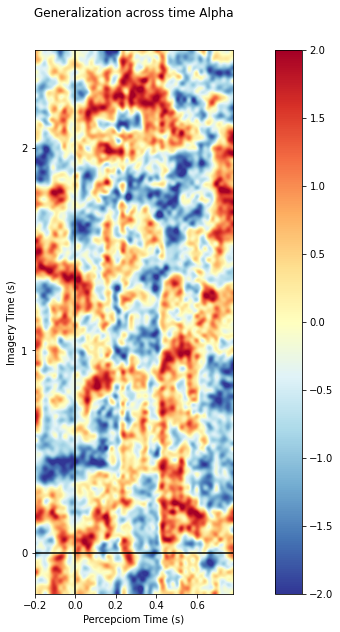

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (-2 , 2))
score = (np.mean(np.array(scores_per_img),axis=0).T + np.mean(np.array(scores_img_per),axis=0))/2
score = scaler.fit_transform(score)
times_per = np.arange(-200,800,20)/1000
times_img = np.arange(-200,2500,20)/1000
fig, ax = plt.subplots(1, figsize = (15,10))
im = ax.matshow(score, interpolation='lanczos', vmin = -2., vmax= 2.,cmap='RdYlBu_r', origin='lower',
                extent=np.hstack([times_per[[0, -1]],times_img[[0, -1]]]))
#im = ax.matshow(score, cmap='RdYlBu_r', origin='lower')
ax.axhline(0., color='k')
ax.axvline(0., color='k')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Percepciom Time (s)')
ax.set_ylabel('Imagery Time (s)')
ax.set_title('Generalization across time Alpha')
plt.colorbar(im, ax=ax)
plt.show()
fig.savefig(trainDir_Raw + 'subj' + subject + '/Generalization across time Alpha', format='png',transparent=True)

In [ ]:
#Analisis en el tiempo percepción
#Visulaizar promedio de generalización percepción vs imaginaciónde los 12 objetos 

svc = SVC(kernel="linear", C=1, decision_function_shape='ovo')
clf = make_pipeline(StandardScaler(), svc)

vectorizer_per = Vectorizer()
vectorizer_img = Vectorizer()

Xp, yp = getEEGXY(per, channels=per.columns[5:69], columnClass='class', ColumnEpoch='epoch')

Xi, yi = getEEGXY(img, channels=img.columns[5:69], columnClass='class', ColumnEpoch='epoch')

Xp = vectorizer_per.fit_transform(Xp, yp)
Xi = vectorizer_img.fit_transform(Xi, yi)

svc = SVC(kernel="linear", C=1, decision_function_shape='ovo')
clf = make_pipeline(StandardScaler(), svc)

pseudo_trials = 4
trials_for_class = dict(zip(classes,[4  for n in range(0,12)]))

scores_per = []
scores_img = []

for i in range(0,100):
  cc = ClusterCentroids(sampling_strategy=trials_for_class,random_state=None,voting='hard')
  Xp_resampled, yp_resampled = cc.fit_resample(Xp, yp)
  Xp_resampled = vectorizer_per.inverse_transform(Xp_resampled)
  Xi_resampled, yi_resampled = cc.fit_resample(Xi, yi)
  Xi_resampled = vectorizer_img.inverse_transform(Xi_resampled)

  time_decod = SlidingEstimator(clf, n_jobs=-1, scoring='accuracy', verbose=True)
  scores_p = cross_val_multiscore(time_decod, Xp_resampled, yp_resampled, cv=4, n_jobs=-1)
  scores_i = cross_val_multiscore(time_decod, Xi_resampled, yi_resampled, cv=4, n_jobs=-1)

  # Mean scores across cross-validation splits
  scores_p = np.mean(scores_p, axis=0)
  scores_i = np.mean(scores_i, axis=0)

  scores_per.append(scores_p)
  scores_img.append(scores_i)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    1.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(

Text(0.5, 1.0, 'Time decoding imagery Alpha')

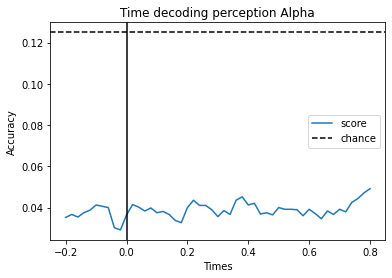

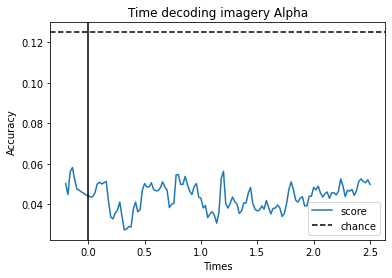

In [ ]:
# Plot perception
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0 , 1))

score= np.mean(np.array(scores_per),axis=0)
#score = scaler.fit_transform(score)
times_per = np.arange(-200,820,20)/1000
fig, ax = plt.subplots()
ax.plot(times_per, score, label='score')
ax.axhline(.125, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('Accuracy')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Time decoding perception Alpha')

# Plot imagery
score= np.mean(np.array(scores_img),axis=0)
#score = scaler.fit_transform(score)
times_img = np.arange(-200,2520,20)/1000
fig, ax = plt.subplots()
ax.plot(times_img, score, label='score')
ax.axhline(.125, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('Accuracy')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Time decoding imagery Alpha')

# Clasificación promediando Morlet en el tiempo

In [ ]:
morlet_alpha = pd.read_csv(path_raw_train +'Caracteristicas_NLPCA_ICA_Morlet_Alpha')
#morlet_alpha_2 = pd.read_csv(path_raw_train_2 +'Caracteristicas_NLPCA_ICA_Morlet_Alpha')
morlet_alpha

,time,condition,class,event,epoch,Morlet_IPC0,Morlet_IPC1,Morlet_IPC2,Morlet_IPC3,Morlet_IPC4,Morlet_IPC5,Morlet_IPC6,Morlet_IPC7,Morlet_IPC8,Morlet_IPC9
0,348,Oreja,41,41,1,-47.057407,-51.030949,-49.868420,-55.285882,-49.441890,-47.085624,-50.239469,-49.347403,-47.398649,-49.885544
1,348,Manzana,11,11,2,-50.599556,-44.627732,-54.871940,-59.603173,-47.378652,-46.357310,-51.421408,-48.188992,-50.797398,-49.082090
2,348,Silla,32,32,3,-48.442646,-45.661791,-52.409895,-60.566180,-47.559097,-53.038776,-53.361604,-53.098660,-51.195280,-47.535820
3,348,Oveja,23,23,5,-47.264308,-46.879215,-49.916123,-56.244583,-42.862782,-46.233544,-51.529494,-48.003626,-48.284381,-49.865804
4,348,Oveja,23,23,6,-43.923870,-45.422304,-51.660788,-53.434225,-41.123499,-46.440791,-47.044031,-48.705278,-46.940674,-46.610567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,348,Oreja,41,41,594,-47.847166,-44.685071,-53.658990,-56.965739,-40.691008,-46.681396,-54.565767,-50.209873,-45.408108,-43.174812
476,348,Silla,32,32,595,-47.763678,-46.266448,-52.636151,-55.787170,-44.380102,-46.389600,-51.736702,-48.329595,-49.256726,-44.718517
477,348,Ojo,42,42,597,-47.965271,-43.738868,-53.367174,-55.515669,-43.013166,-46.300013,-54.255274,-51.212056,-47.669321,-46.869723
478,348,Ojo,42,42,598,-49.492926,-47.449498,-54.297699,-58.577518,-41.698855,-47.078230,-50.453570,-47.821650,-47.351523,-46.463714


In [ ]:
X = morlet_alpha.to_numpy()[:,5:15]*100000
X = np.concatenate((X,X), axis=0)
y = morlet_alpha.to_numpy()[:,2]
y=y.astype('int')
y = np.concatenate((y,y), axis=0)
classes_names = list(morlet_alpha['condition'].unique())
X.shape

(960, 10)

13.333333333333334


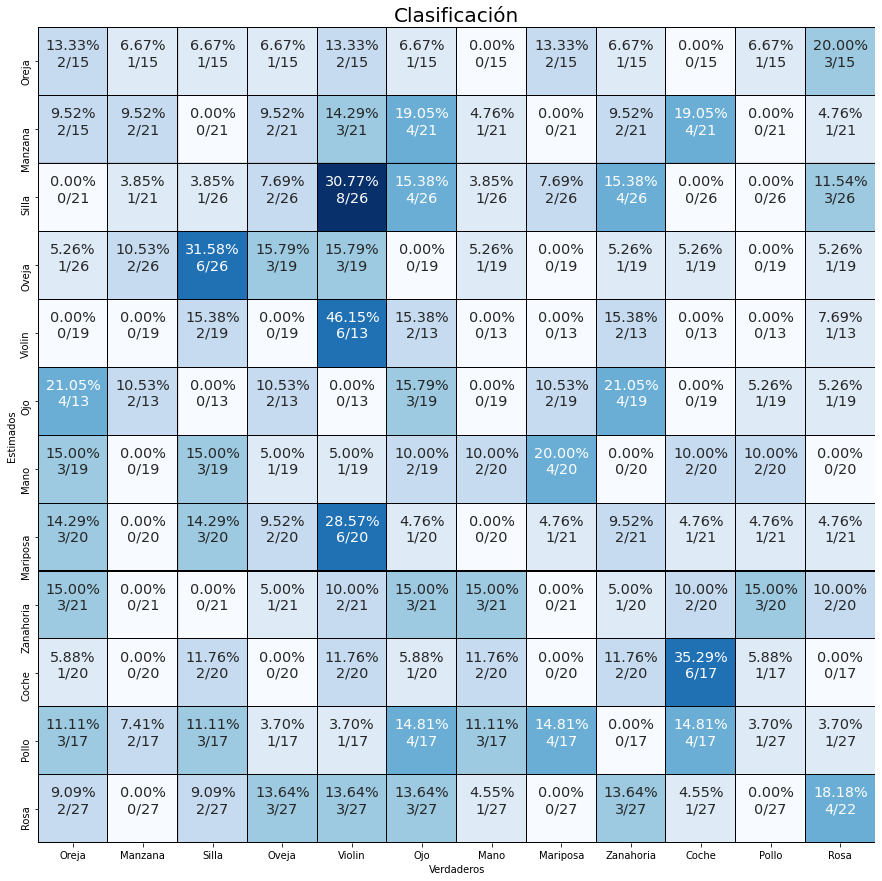

In [ ]:
# Assemble a classifier
svc = SVC(kernel="linear", C=1, decision_function_shape='ovo')
lda = LinearDiscriminantAnalysis()
# Use scikit-learn Pipeline with cross_val_score function
#We will train the classifier on  visual vs null trials on EEG
clf = make_pipeline(StandardScaler(), svc)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25,random_state=0)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred)*100)
plot_matriz_confusion(y_test, y_pred, classes_names, save=None, titulo='Clasificación', figsize=(15,15))

In [ ]:
scores[0,:,:]

array([[0.07916667, 0.06458333, 0.07083333, ..., 0.07083333, 0.075     ,
        0.06458333],
       [0.07708333, 0.075     , 0.08333333, ..., 0.07291667, 0.07291667,
        0.0875    ],
       [0.075     , 0.08333333, 0.07916667, ..., 0.07708333, 0.07708333,
        0.075     ],
       ...,
       [0.075     , 0.08125   , 0.08333333, ..., 0.075     , 0.07916667,
        0.07708333],
       [0.08125   , 0.0875    , 0.0875    , ..., 0.08541667, 0.08125   ,
        0.07916667],
       [0.08541667, 0.08125   , 0.08958333, ..., 0.07916667, 0.08333333,
        0.07291667]])

In [ ]:
# Assemble a classifier
svc = SVC(kernel="linear", C=1)
lda = LinearDiscriminantAnalysis()
# Use scikit-learn Pipeline with cross_val_score function
#We will train the classifier on  visual vs null trials on EEG
clf = make_pipeline(StandardScaler(), svc)

y_testAcumulado = []
y_predictAcumulado = []

skf = StratifiedKFold(n_splits=4)
for train_index, test_index in skf.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print(accuracy_score(y_test, y_pred))

  y_testAcumulado.append(y_test)
  y_predictAcumulado.append(y_pred)

y_testTot = np.array(y_testAcumulado).reshape((1, -1))
y_predict = np.array(y_predictAcumulado).reshape((1, -1))

plot_matriz_confusion(list(y_testTot[0]), list(y_predict[0]), classes_names, save=None, titulo='Clasificación', figsize=(21,30))